# Digit Recognizer
This is a Jupyter Notebook for the competition **[Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/overview)** in kaggle to classify MNIST handwritten number using Convolutuon Neural Network with PyTorch. Training is conducted by using MPS (Metal Performance Shaders) on Mac mini M2 pro.

## 1. Loading Libraries and Device configuration

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import v2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler

# Set the directory path
path = '' # If you put the file in the same directory, set it blank

# Device configuration
# For using MPS on MacOS
if torch.backends.mps.is_available():
    device = torch.device("mps")
# For using CUDA
elif torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device set to: {device}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/site

AttributeError: _ARRAY_API not found

Device set to: mps


## 2. Loading train and test data, and Data augmentation

In [3]:
# Read train.csv
data = np.loadtxt(path + "train.csv", delimiter=',', dtype='int64', skiprows=1)
print(f"train.csv: {data.shape}")

# Split data into X and label
X = data[:,1:]
label = data[:,0]

train.csv: (42000, 785)


Write the parameters in the dict `param_grid`, then `params = list(ParameterGrid(param_grid))` will return all the combinations of the each parameter.

In [4]:
# Parameter grid
param_grid = {
    'optim': ['SDG'],
    'mom': [0.95, 0.9, 0.85],
    'lr': [5e-2,1e-2,5e-3]
}

# best parameter
param_grid = {
    'lr': [0.005],
    'mom': [0.9],
    'optim': ['SDG']
}

params = list(ParameterGrid(param_grid))
print(f"There are {len(params)} parameter combinations.")

There are 1 parameter combinations.


## Data Augmentation
Based on the original data, augmented it by these methods:
- **RandomRotation:** Randomly rotate the image by ±5,10,15,20 degrees
- **RandomAffine** Random affine transformation with degree rotation ±10 and scale from the 0.9 to 1.1

`augment_factor` in `CustomDataset` decides how many times the original data will be augmented.

In [5]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, augment_factor=1):
        self.X = X
        self.y = y
        self.transform = transform
        self.augment_factor = augment_factor

    def __len__(self):
        return len(self.y) * self.augment_factor

    def __getitem__(self, idx):
        original_idx = idx // self.augment_factor
        image = self.X[original_idx].reshape(28, 28)
        image = torch.from_numpy(image).clone().unsqueeze(0)
        label = self.y[original_idx]
        if self.transform and self.augment_factor > 1:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
augmentation_transforms = v2.Compose([
    v2.RandomRotation(np.random.choice([5,10,15,20])),  # Randomly rotate the image by ±5,10,15,20 degrees
    v2.RandomAffine(10, scale=(0.9, 1.1)),  # Random affine transformation (scale)
    v2.ToDtype(torch.float32)
])

## Split the data into train and test
Train data is splitted as x0.8 of the original data, then standardized.

Number of original data: 33600
Number of augmented samples: 1680000, 50 times as many as the original data.
------------------------------------
Sample of train_dataset


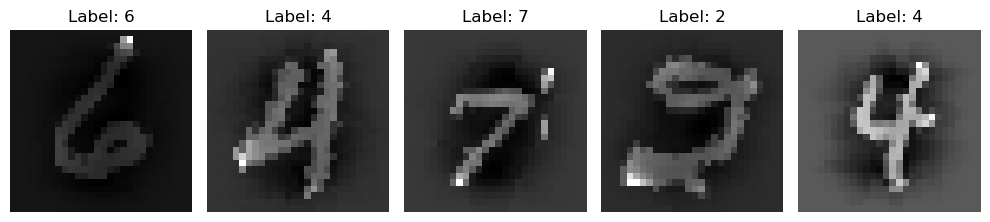

------------------------------------
Sample of test_dataset


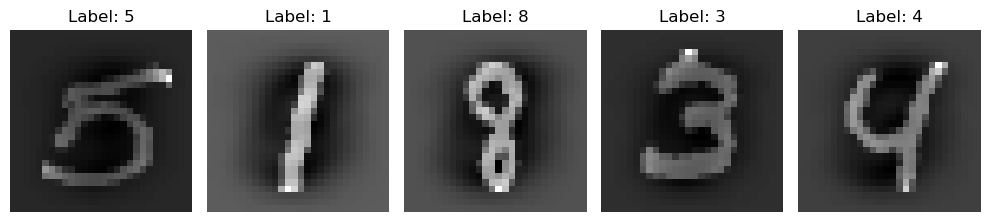

In [6]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train[0])
#print(X_test[0])

# Create PyTorch Datasets and DataLoaders
train_dataset = CustomDataset(X_train, y_train, transform=augmentation_transforms, augment_factor=50)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Show the each amount of original and augmented data
print(f"Number of original data: {len(X_train)}")
print(f"Number of augmented samples: {len(train_dataset)}, {int(len(train_dataset) / len(X_train))} times as many as the original data.")
print("------------------------------------")

# Visualize a few augmented images
def visualize_augmented_data(dataset, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        image, label = dataset[np.random.randint(len(dataset))]
        #print("image:",image)
        image = image.squeeze().numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Sample of train_dataset")
visualize_augmented_data(train_dataset)
print("------------------------------------")
print("Sample of test_dataset")
visualize_augmented_data(test_dataset)

## 3. CNN class
### Layers
**1: Convolution**
- **Convolution:** in_channels = 1, out_channels = 128, kernel_size = 2, stride = 1, padding = 1
- **ReLU**
- **MaxPool:** kernel_size = 2, stride = 2
- **Dropout:** p = 0.2

**2: Convolution**
- **Convolution:** in_channels = 128, out_channels = 256, kernel_size = 2, stride = 1, padding = 1
- **ReLU**
- **MaxPool:** kernel_size = 2, stride = 2
- **Dropout:** p = 0.2


**3: Fully Connected Layer**
- **Flatten**
- **Linear:** in_features = 256 * 7 * 7, out_features = 128
- **ReLU**
- **Dropout:** p = 0.2
- **Linear:** in_features = 128, out_features = 10

### Early Stop
After Epoch 10, if the mean of the loss in the last 5 epochs is bigger than the mean of the loss in the last 6-10 epochs, break the loop (e.g. at Epoch 13, compare the mean of the loss in 9-13 epochs and 4-8 epochs).

In [7]:
# CNN class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    loss_list = []
    best_model = None
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Show the progress per each epoch
        print(f"Epoch [ {epoch+1} / {epochs} ] Loss: {running_loss/len(train_loader):.8f}")
        
        loss_list.append(running_loss / len(train_loader))
        
        # Save the best model
        if loss_list[-1] == min(loss_list):
            best_model = model
        
        # Early stop
        if epoch >= 10 and (np.mean(loss_list[-3:]) > np.mean(loss_list[-6:-3])) :
            print("Early stop")
            break
    
    return min(loss_list), loss_list.index(min(loss_list))+1, best_model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.float()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Show the Test Accuracy
    #print(f"Test Accuracy: {accuracy:.4f}")
    
    return accuracy

## 4. Train the model
*If you have a pretrained model, skip the training and go to the next section.

In [7]:
# Training and Optimization loop
accuracy = []
best_model = None

# Time to start training
start_time = time.time()

for i,param in enumerate(params):
    # Show each epoch and parameters 
    print(i+1, "/", len(params), param)
    
    # Initialize the model and criterion
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    if param['optim'] == 'SDG':
        optimizer = optim.SGD(model.parameters(), lr = param['lr'], momentum = param['mom'])
    if param['optim'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr = param['lr'])
    
    # Train the model
    loss, epoch, model = train_model(model, train_loader, criterion, optimizer, epochs=100)
    
    # Evaluate the model for the test data
    test_accuracy = evaluate_model(model, test_loader)
    accuracy.append(test_accuracy)
    print(f"Accuracy: {accuracy[-1] * 100:.2f}%, Loss: {loss:.8f}, Epoch: {epoch:.0f}")
    
    # Save the model if it is the best one
    if accuracy[-1] == min(accuracy):
        best_model = model

# Time to end training
end_time = time.time()
elapsed_time = end_time - start_time

# Show the time for training
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"Training completed in: {hours:02}:{minutes:02}:{seconds:02}")

# Show the result
print(f"Best Accuracy: {max(accuracy) * 100:.2f}%")
print(f"Best parameter: {params[accuracy.index(max(accuracy))]}")

1 / 1 {'lr': 0.005, 'mom': 0.9, 'optim': 'SDG'}
Epoch [ 1 / 100 ] Loss: 0.08162148
Epoch [ 2 / 100 ] Loss: 0.02754514
Epoch [ 3 / 100 ] Loss: 0.01926412
Epoch [ 4 / 100 ] Loss: 0.01489655
Epoch [ 5 / 100 ] Loss: 0.01247146
Epoch [ 6 / 100 ] Loss: 0.01082853
Epoch [ 7 / 100 ] Loss: 0.00947593
Epoch [ 8 / 100 ] Loss: 0.00840519
Epoch [ 9 / 100 ] Loss: 0.00756552
Epoch [ 10 / 100 ] Loss: 0.00745458
Epoch [ 11 / 100 ] Loss: 0.00682921
Epoch [ 12 / 100 ] Loss: 0.00625108
Epoch [ 13 / 100 ] Loss: 0.00610010
Epoch [ 14 / 100 ] Loss: 0.00558287
Epoch [ 15 / 100 ] Loss: 0.00524585
Epoch [ 16 / 100 ] Loss: 0.00518798
Epoch [ 17 / 100 ] Loss: 0.00489968
Epoch [ 18 / 100 ] Loss: 0.00463750
Epoch [ 19 / 100 ] Loss: 0.00451322
Epoch [ 20 / 100 ] Loss: 0.00428026
Epoch [ 21 / 100 ] Loss: 0.00410679
Epoch [ 22 / 100 ] Loss: 0.00384281
Epoch [ 23 / 100 ] Loss: 0.00369597
Epoch [ 24 / 100 ] Loss: 0.00384278
Epoch [ 25 / 100 ] Loss: 0.00353290
Epoch [ 26 / 100 ] Loss: 0.00351451
Epoch [ 27 / 100 ] Loss: 

In [8]:
# Save the model with the timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
file_path = f"{path}cnn_model_{timestamp}.pth"
torch.save(best_model.state_dict(), file_path)
print(f"The model has been successfully saved as {file_path}.")

The model has been successfully saved as cnn_model_20241221_1548.pth.


## 5. Make Predictions and Save the result for submission
*If you have a pretrained model, load the model in the next cell, otherwise skip it.

In [17]:
# Load the model if you have a pretrained one, otherwise skip this cell.

# set the file path
file_path = "cnn_model_20241218_0116.pth" # your_directory/your_file_name

best_model = CNN().to(device)
best_model.load_state_dict(torch.load(file_path, weights_only=True))
best_model.eval()
print(f"The pretrained model {file_path} has been successfully loaded.")

The pretrained model cnn_model_20241218_0116.pth has been successfully loaded.


In [19]:
# Function to make predictions
def make_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images in data_loader:
            images = images.reshape(-1,1,28,28)
            images = images.float().to(device)
            #print(images.shape)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return np.array(predictions)

# Load the test data for submission
X_sub = np.loadtxt(path + 'test.csv', delimiter=',', dtype='int64', skiprows=1)
X_sub = scaler.transform(X_sub)
sub_loader = DataLoader(dataset=X_sub.reshape(-1,28,28), batch_size=128, shuffle=False)

# Make predictions
predictions = make_predictions(best_model, sub_loader, device)
formatted_data = [[i+1, predictions[i]] for i in range(len(predictions))]

# Show the submission data
submission = pd.DataFrame(formatted_data, columns = ["ImageId", "Label"])
print(f"submission: {submission.shape}")
submission.head()

submission: (28000, 2)


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [22]:
# Save the predictions as a csv file with the timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
submission_file = f"{path}submission_cnn_{timestamp}.csv"
submission.to_csv(submission_file, index = False)
print(f"The predictions have been successfully saved as {submission_file}.")

The predictions have been successfully saved as submission_cnn_20241223_1911.csv.


## 6. Notification with [Jupyternotify](https://pypi.org/project/jupyternotify/)

In [11]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [12]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [13]:
%%notify
time.sleep(1)

<IPython.core.display.Javascript object>